In [1]:
#This notebook tests clustering approach under the spherical coordinates

In [2]:
#%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from trackml.dataset import load_event, load_dataset
from trackml.score import score_event

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

path_to_train = "train_1"
event_prefix = "event000001000"

hits, cells, particles, truth = load_event(os.path.join(path_to_train, event_prefix))


def get_training_sample(path_to_data, event_names):
    events = []
    track_id = 0

    for name in event_names:
        # Read an event
        hits, cells, particles, truth = load_event(os.path.join(path_to_data, name))

        # Generate new vector of particle id
        particle_ids = truth.particle_id.values
        particle2track = {}
        for pid in np.unique(particle_ids):
            particle2track[pid] = track_id
            track_id += 1
        hits['track_id'] = [particle2track[pid] for pid in particle_ids]

        # Collect hits
        events.append(hits)

    # Put all hits into one sample with unique tracj ids
    data = pd.concat(events, axis=0)
    return data

#Take the first 5 event datasets
start_event_id = 1000
n_train_samples = 5
train_event_names = ["event0000{:05d}".format(i) for i in range(start_event_id, start_event_id+n_train_samples)]
train_data = get_training_sample(path_to_train, train_event_names)

train_data.head(20)

,hit_id,x,y,z,volume_id,layer_id,module_id,track_id
0,1,-64.409897,-7.163700,-1502.5,7,2,1,0
1,2,-55.336102,0.635342,-1502.5,7,2,1,477
2,3,-83.830498,-1.143010,-1502.5,7,2,1,0
3,4,-96.109100,-8.241030,-1502.5,7,2,1,3556
4,5,-62.673599,-9.371200,-1502.5,7,2,1,4811
5,6,-57.068699,-8.177770,-1502.5,7,2,1,1384
6,7,-73.872299,-2.578900,-1502.5,7,2,1,10496
7,8,-63.853500,-10.868400,-1502.5,7,2,1,10271
8,9,-97.254799,-10.889100,-1502.5,7,2,1,7406
9,10,-90.292900,-3.269370,-1502.5,7,2,1,1045


In [6]:
len(train_data)

583142

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

def create_one_event_submission(event_id, hits, labels):
    sub_data = np.column_stack(([event_id]*len(hits), hits.hit_id.values, labels))
    submission = pd.DataFrame(data=sub_data, columns=["event_id", "hit_id", "track_id"]).astype(int)
    return submission

#Coordinate transformation
def cart2spherical(cart):
    r = np.linalg.norm(cart, axis=0)
    theta = np.degrees(np.arccos(cart[2] / r))
    phi = np.degrees(np.arctan2(cart[1], cart[0]))
    return np.vstack((r, theta, phi))

def cart2helix(cart):
    r = np.linalg.norm(cart, axis=0)
    rp = np.linalg.norm(cart[:2,:], axis=0)
    x1 = cart[0]/r
    y1 = cart[1]/r
    z1 = cart[2]/r
    z2 = cart[2]/rp
    phi = np.arctan2(cart[1], cart[0])
    
    
    return np.vstack((x1, y1, z1, z2))


#DBSCAN Clusterering approach
class DBSCANClusterer(object):
    
    def __init__(self, eps):
        self.eps = eps
        
    
    def _preprocess(self, hits):
        
        xyz = hits.loc[:, ['x', 'y', 'z']].values.transpose()

            
        helix = cart2helix(xyz) 
        hits['x1'] = pd.Series(helix[0])
        hits['y1'] = pd.Series(helix[1])
        hits['z1'] = pd.Series(helix[2])
        hits['z2'] = pd.Series(helix[3])       
        
        ss = StandardScaler()
        X = ss.fit_transform(hits[['x1', 'y1', 'z1', 'z2']].values)        
        
        return X
    
    
    def predict(self, hits):
        
        X = self._preprocess(hits)
        
        cl = DBSCAN(eps=self.eps, min_samples=1, algorithm='kd_tree')
        labels = cl.fit_predict(X)
        
        return labels

for eps in np.linspace(0.001, 0.008, num=10):    
 model = DBSCANClusterer(eps=eps)
 labels = model.predict(hits)
 submission = create_one_event_submission(0, hits, labels)

 #This is the score of the algorithm on the training set itself
 score = score_event(truth, submission)
 print("Your score for eps = {:.4f}: {:.5f}".format(eps,score))

Your score for eps = 0.0010: 0.03856
Your score for eps = 0.0018: 0.08749
Your score for eps = 0.0026: 0.12504
Your score for eps = 0.0033: 0.15353


KeyboardInterrupt: 

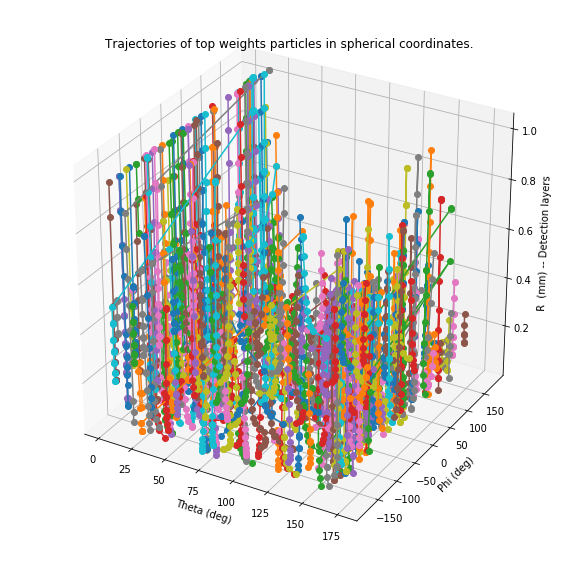

In [73]:
from mpl_toolkits.mplot3d import Axes3D

def cart2spherical(cart):
    r = np.linalg.norm(cart, axis=0)
    theta = np.degrees(np.arccos(cart[2] / r))
    phi = np.degrees(np.arctan2(cart[1], cart[0]))
    return np.vstack((r/3000, theta, phi))

NUM_PARTICLES = 450
truth_dedup = truth.drop_duplicates('particle_id')
truth_sort = truth_dedup.sort_values('weight', ascending=False)
truth_head = truth_sort.head(NUM_PARTICLES)

# Get points where the same particle intersected subsequent layers of the observation material
p_traj_list = []
for _, tr in truth_head.iterrows():
    p_traj = truth[truth.particle_id == tr.particle_id][['tx', 'ty', 'tz']]
    p_traj_list.append(p_traj)
    
# Convert to spherical coordinate.
rtp_list = []
for p_traj in p_traj_list:
    xyz = p_traj.loc[:, ['tx', 'ty', 'tz']].values.transpose()
    rtp = cart2spherical(xyz).transpose()
    rtp_df = pd.DataFrame(rtp, columns=('r', 'theta', 'phi'))
    rtp_list.append(rtp_df)

# Plot with spherical coordinates.
fig2 = plt.figure(figsize=(10, 10))
ax = fig2.add_subplot(111, projection='3d')
for rtp_df in rtp_list:
    ax.plot(
        xs=rtp_df.theta,
        ys=rtp_df.phi,
        zs=rtp_df.r,
        marker='o')
ax.set_xlabel('Theta (deg)')
ax.set_ylabel('Phi (deg)')
ax.set_zlabel('R  (mm) -- Detection layers')
plt.title('Trajectories of top weights particles in spherical coordinates.')
plt.show()

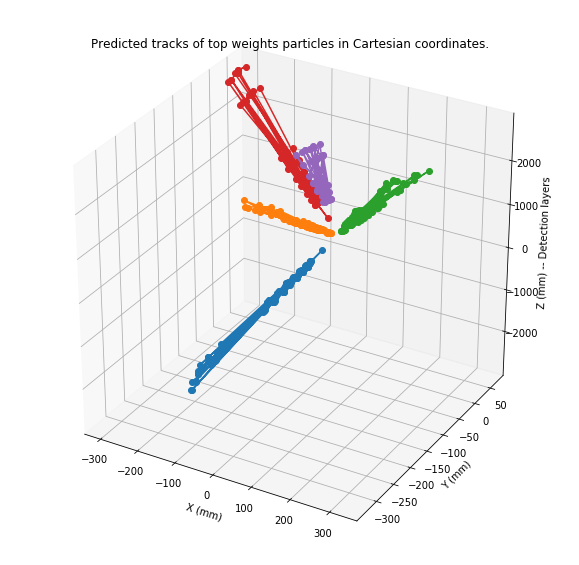

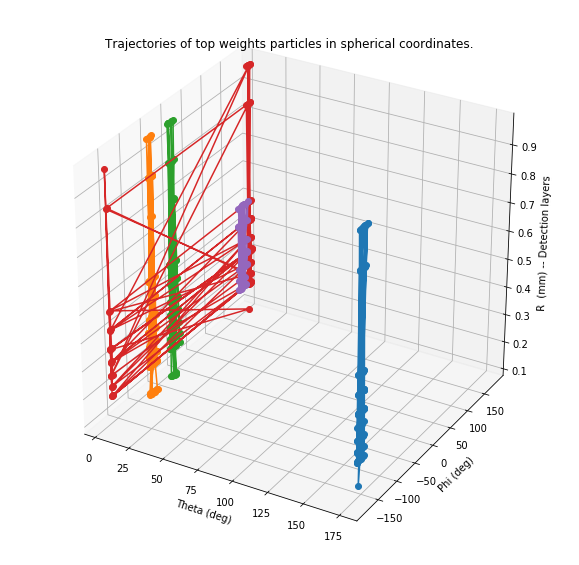

In [74]:
hits['track_id']=submission['track_id']
hits['nhits']=submission.groupby('track_id')['event_id'].transform('count')
sub = hits.sort_values('nhits', axis=0, ascending=False).iloc[:500]
sub.head(10)

#Plot the predicted tracks
pred_traj_list = []

for track in sub.track_id.unique():
  #print(sub[sub['track_id'] == track]['hit_id'])
  pred_traj_list.append(sub[sub['track_id'] == track][['x', 'y', 'z']]) 
   

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
for p_traj in pred_traj_list:
    ax.plot(
        xs=p_traj.x,
        ys=p_traj.y,
        zs=p_traj.z,
        marker='o')
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm) -- Detection layers')
plt.title('Predicted tracks of top weights particles in Cartesian coordinates.')    


# Convert to spherical coordinate.
rtp_list = []
for p_traj in pred_traj_list:
    xyz = p_traj.loc[:, ['x', 'y', 'z']].values.transpose()
    rtp = cart2spherical(xyz).transpose()
    rtp_df = pd.DataFrame(rtp, columns=('r', 'theta', 'phi'))
    rtp_list.append(rtp_df)

# Plot with spherical coordinates.
fig2 = plt.figure(figsize=(10, 10))
ax = fig2.add_subplot(111, projection='3d')
for rtp_df in rtp_list:
    ax.plot(
        xs=rtp_df.theta,
        ys=rtp_df.phi,
        zs=rtp_df.r,
        marker='o')
ax.set_xlabel('Theta (deg)')
ax.set_ylabel('Phi (deg)')
ax.set_zlabel('R  (mm) -- Detection layers')
plt.title('Trajectories of top weights particles in spherical coordinates.')

plt.show()